## _`Import Dependencies`_


In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib

## _`Data Collection`_


In [ ]:
file = 'diabetes.csv'
data = pd.read_csv(file)
data.head()  # Display the first 5 rows of the dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## _`Data Analysis & Preprocessing`_


In [194]:
data.shape

(768, 9)

In [ ]:
data.info()  # Get a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [196]:
# Other way To See Column Data Types
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [197]:
# Other Way to Check Missing Values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
data.describe()  # Generate descriptive statistics

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [199]:
numerical_cols = data.select_dtypes(
    include=['int64', 'float64']).columns.to_list()
numerical_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

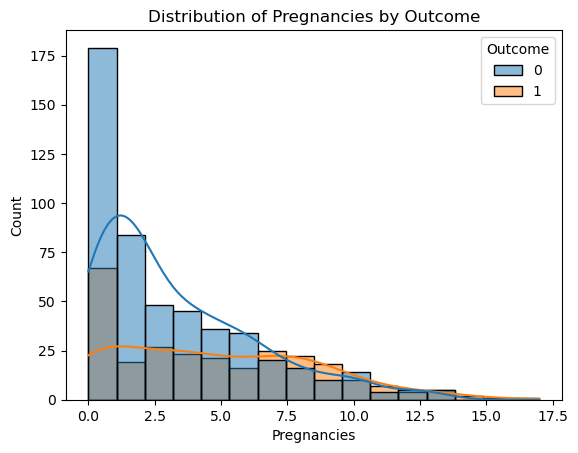

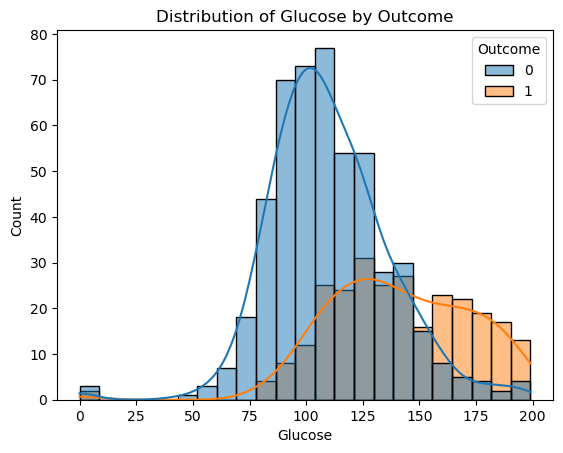

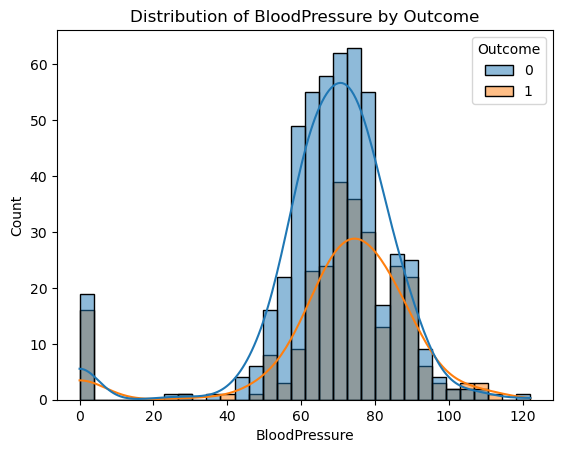

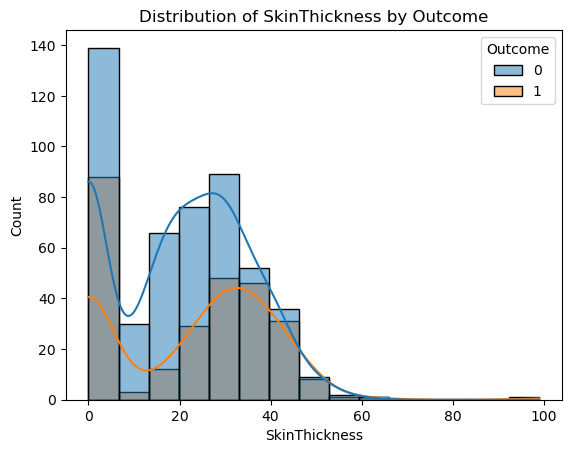

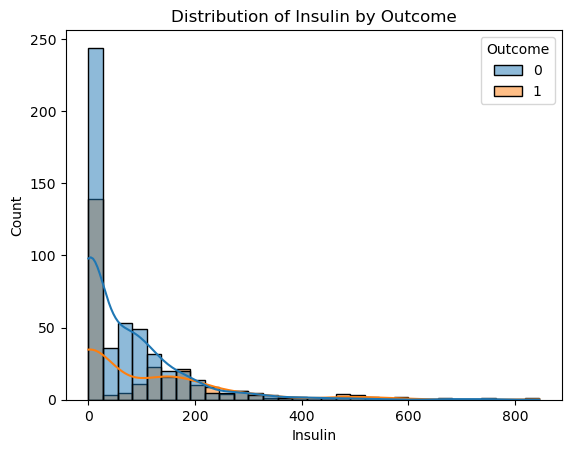

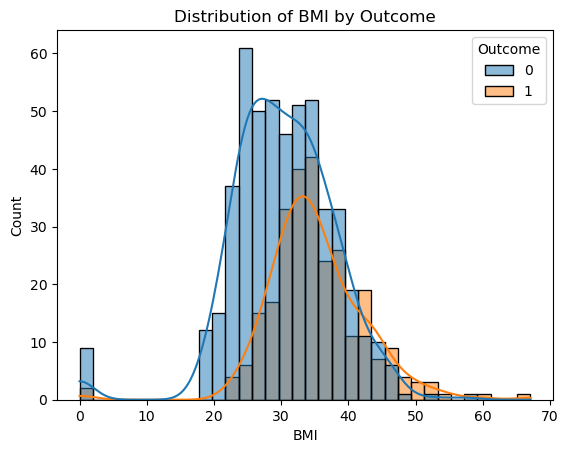

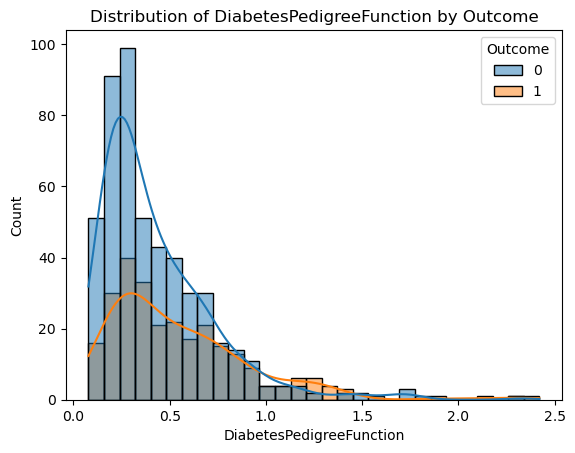

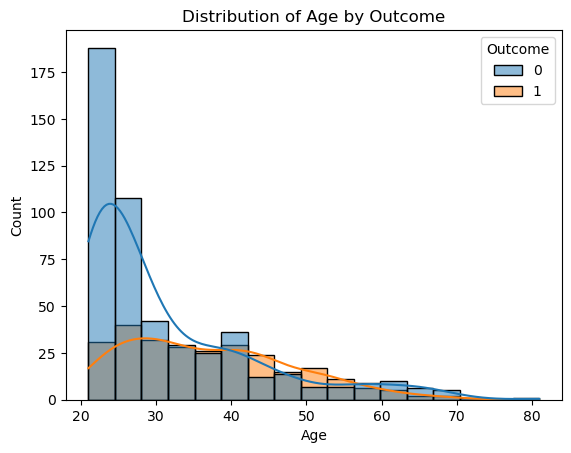

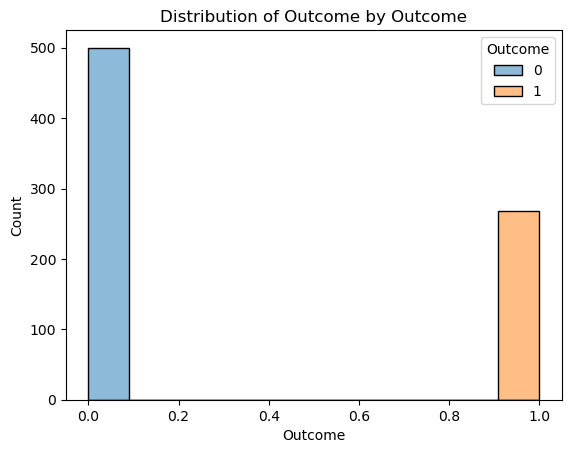

In [200]:
# Features Distribution
for col in numerical_cols:
    sns.histplot(data, x=col, hue='Outcome', kde=True)
    plt.title(f'Distribution of {col} by Outcome')
    plt.show()

In [ ]:
for col in data.columns:
    print(col, "Has number of Cells with Zeros -> ", len(data[data[col] == 0]))

Pregnancies Has number of Cells with Zeros ->  111
Glucose Has number of Cells with Zeros ->  5
BloodPressure Has number of Cells with Zeros ->  35
SkinThickness Has number of Cells with Zeros ->  227
Insulin Has number of Cells with Zeros ->  374
BMI Has number of Cells with Zeros ->  11
DiabetesPedigreeFunction Has number of Cells with Zeros ->  0
Age Has number of Cells with Zeros ->  0
Outcome Has number of Cells with Zeros ->  500


_`Data Features -> Has Many Zeros` -> Let's Handle it_


In [ ]:
cols_to_impute = ['Pregnancies', 'SkinThickness', 'Insulin']

# Replace 0s with NaN for the specified columns
data[cols_to_impute] = data[cols_to_impute].replace(0, np.nan)

# Impute missing values with the median of each column (Better for Skewed Data)
data[cols_to_impute] = data[cols_to_impute].fillna(
    data[cols_to_impute].median())

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.423177,120.894531,69.105469,29.108073,140.671875,31.992578,0.471876,33.240885,0.348958
std,2.980481,31.972618,19.355807,8.791221,86.383060,7.884160,0.331329,11.760232,0.476951
min,1.000000,0.000000,0.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,62.000000,25.000000,121.500000,27.300000,0.243750,24.000000,0.000000
50%,4.000000,117.000000,72.000000,29.000000,125.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


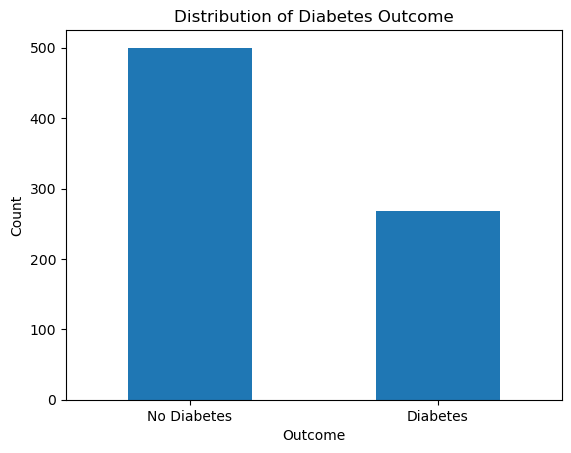

In [203]:
data['Outcome'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'], rotation=0)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Diabetes Outcome')
plt.show()

_`Unbalanced Target -> ` we will handle it by SMOTE_


<Axes: xlabel='Outcome'>

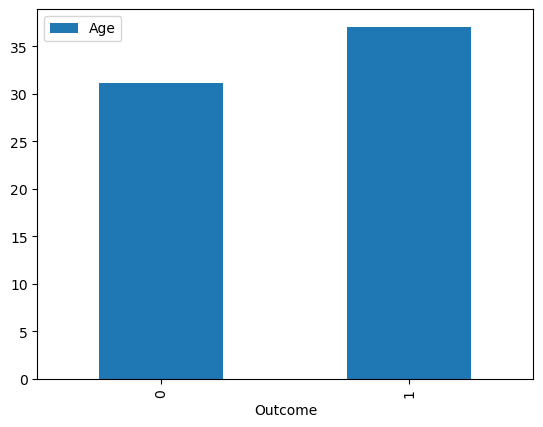

In [204]:
# Age Averages for Both Groups
data.groupby('Outcome').agg({'Age': 'mean'}).plot(kind='bar')

<Axes: xlabel='Outcome'>

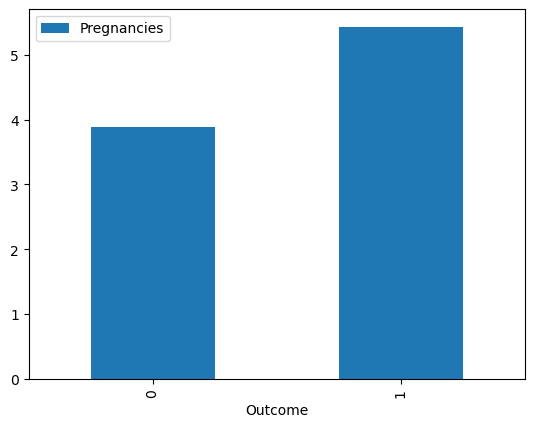

In [205]:
# Pregnancies for Both Groups
data.groupby('Outcome').agg({'Pregnancies': 'mean'}).plot(kind='bar')

### _`Handling Outliers`_


In [ ]:
# Display How many number of Outliers in Each Numerical Column
for col in numerical_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f'{col}: has {len(outliers)} outliers')
    if len(outliers) > 0:
        print("Clipping....")
        data[col] = np.clip(data[col], lower_bound, upper_bound)
        print(f'Outliers in {col} have been clipped.')
        print("=" * 50)

Pregnancies: has 14 outliers
Clipping....
Outliers in Pregnancies have been clipped.
Glucose: has 5 outliers
Clipping....
Outliers in Glucose have been clipped.
BloodPressure: has 45 outliers
Clipping....
Outliers in BloodPressure have been clipped.
SkinThickness: has 87 outliers
Clipping....
Outliers in SkinThickness have been clipped.
Insulin: has 346 outliers
Clipping....
Outliers in Insulin have been clipped.
BMI: has 19 outliers
Clipping....
Outliers in BMI have been clipped.
DiabetesPedigreeFunction: has 29 outliers
Clipping....
Outliers in DiabetesPedigreeFunction have been clipped.
Age: has 9 outliers
Clipping....
Outliers in Age have been clipped.
Outcome: has 0 outliers


In [207]:
# Check Duplicates
data.duplicated().sum()

np.int64(0)

### _`Split Data into Features and Target`_


In [ ]:
# DataFrame of Features
# Similar to data.drop(columns='Outcome', axis=1)
X = data.drop(columns='Outcome')

# Series of Target
y = data['Outcome']

X.shape, y.shape

((768, 8), (768,))

In [209]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

### _`Feature Scaling -> Standardization`_


In [210]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[ 0.55496153,  0.86192556,  0.09269135, ...,  0.20935933,
         0.58892732,  1.44569096],
       [-1.17338581, -1.15943299, -0.33020145, ..., -0.78425421,
        -0.37810147, -0.189304  ],
       [ 1.24630046,  1.98490253, -0.47116571, ..., -1.25267202,
         0.74659506, -0.10325164],
       ...,
       [ 0.20929206, -0.00437096,  0.09269135, ..., -0.84103213,
        -0.74949659, -0.27535637],
       [-1.17338581,  0.15605432, -0.75309424, ..., -0.28744744,
        -0.38510892,  1.18753386],
       [-1.17338581, -0.90275254, -0.04827292, ..., -0.24486401,
        -0.50423566, -0.87772293]])

In [211]:
X_scaled.shape, y.shape

((768, 8), (768,))

## _`Train-Test Split`_


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
X_resampled.shape, y_resampled.shape

((1000, 8), (1000,))

In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=7)

In [ ]:
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((750, 8), (250, 8), (750,), (250,))

## _`Build ML Model`_


In [216]:
svm = SVC()

### _`Training`_


In [217]:
svm.fit(X_train, y_train)

SVC()

### _`Evaluation`_


In [218]:
# Prediction on Train Data
y_pred_train = svm.predict(X_train)
y_pred_train

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,

In [219]:
# Prediction on Test Data
y_pred = svm.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1])

### _`Measure Metrics`_


Classification Report - Train Data
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       375
           1       0.82      0.87      0.84       375

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.84      0.84      0.84       750



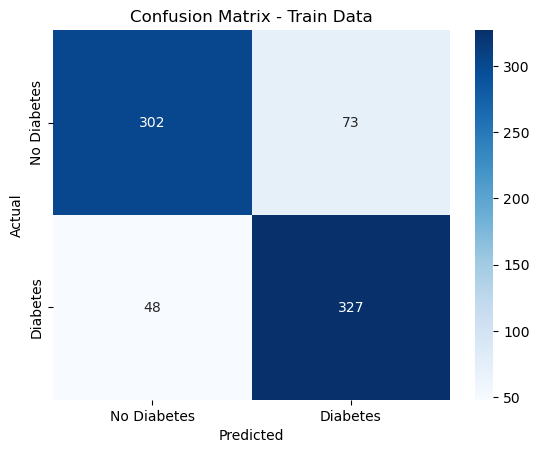

In [ ]:
# On Train Data
print("Classification Report - Train Data")
cr = classification_report(y_train, y_pred_train)
print(cr)

print("="*50)

cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Data')
plt.show()

Classification Report - Train Data
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       125
           1       0.77      0.85      0.81       125

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



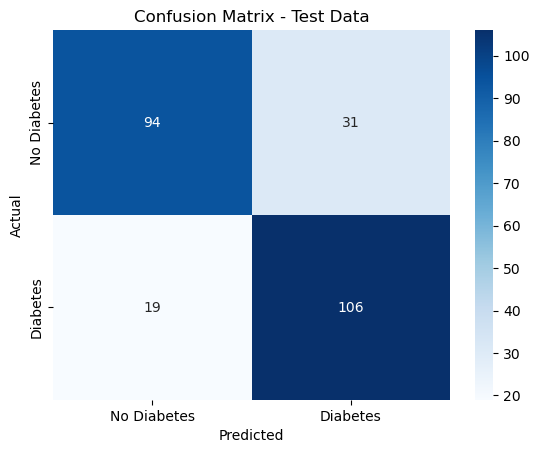

In [ ]:
# On Test Data
print("Classification Report - Train Data")
cr = classification_report(y_test, y_pred)
print(cr)

print("="*50)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

## _`Optimization`_


In [ ]:
# Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(class_weight='balanced'),
                    param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

svm = grid.best_estimator_
svm

SVC(C=1, class_weight='balanced', gamma='auto')

Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       125
           1       0.77      0.85      0.81       125

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



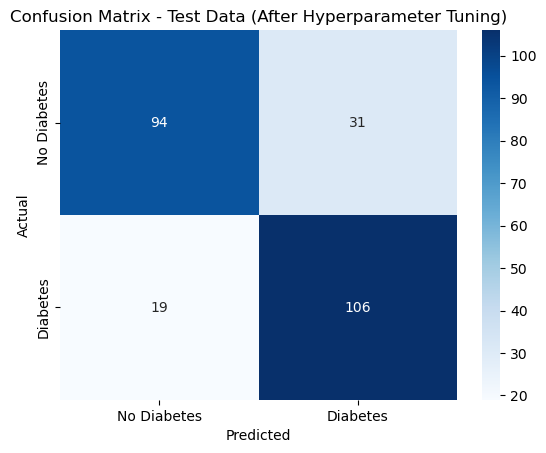

In [ ]:
print("Best Hyperparameters:", grid.best_params_)

y_pred = svm.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data (After Hyperparameter Tuning)')
plt.show()

## _`Deployment` -> Flask_


In [ ]:
# Making a Predictive System
input_data = (6, 148, 72, 35, 0, 33.6, 0.627, 50)

# Changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# Standardize the input data
std_data = scaler.transform(input_data_reshaped)

prediction = svm.predict(std_data)

if prediction[0] == 0:
    print("The person is not diabetic")
else:
    print("The person is diabetic")

The person is not diabetic


c:\Users\mr\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### _`Save Model and Scaler`_


In [228]:
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Model and Scaler saved as svm_model.pkl and scaler.pkl')

Model and Scaler saved as svm_model.pkl and scaler.pkl
